# A Jupyter Notebook to Perform Pricing Using the Bates Formula
This notebook demonstrates the implementation of the Bates formula for pricing Bonus Certificates. It includes steps for importing libraries, defining the formula, setting parameters, simulating asset price paths, calculating option prices, and visualizing results.

## Import Required Libraries
Import necessary libraries such as NumPy, SciPy, and Matplotlib for numerical computations and visualizations.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))  # Adds the parent directory to the Python path

In [2]:
# data
S0 = 81.25
B = 85
L = 65
H = 55
q = 0.02
T = 328/365 # 08/04/25 - 16/06/26

In [3]:
# Import Required Libraries
from src.payout.payout import calculate_bonus_certificate_payout, plot_payout

In [4]:
plot_payout(B, H, S0)

## Calculate interest rate
Obtain interest rate from forward prices of the vanilla market prices

In [5]:
from src.interest_rates.calculate_interest_rates import calculate_interest_rate_from_parity, plot_interest_rates
import pandas as pd

In [6]:
# Load the CSV file into a pandas DataFrame
file_path = "../data/marketDataClose25-04/060625.csv"  # Adjust the path if necessary
df = pd.read_csv(file_path)
df['Spot'] = S0
df = df[['Bid_Call', 'Ask_Call', 'Bid_Put', 'Ask_Put', 'Spot', 'Strike', 'IV_Put', 'IV_Call']]

# Display the first few rows of the DataFrame
print(df.head())

   Bid_Call  Ask_Call  Bid_Put  Ask_Put   Spot  Strike  IV_Put  IV_Call
0      34.3      38.3      0.0     1.40  81.25    45.0   0.662    0.662
1      29.4      33.4      0.0     1.40  81.25    50.0   0.662    0.662
2      24.4      28.4      0.0     1.55  81.25    55.0   0.659    0.659
3      19.5      23.5      0.0     2.25  81.25    60.0   0.646    0.646
4      14.6      18.6      0.0     1.55  81.25    65.0   0.599    0.599


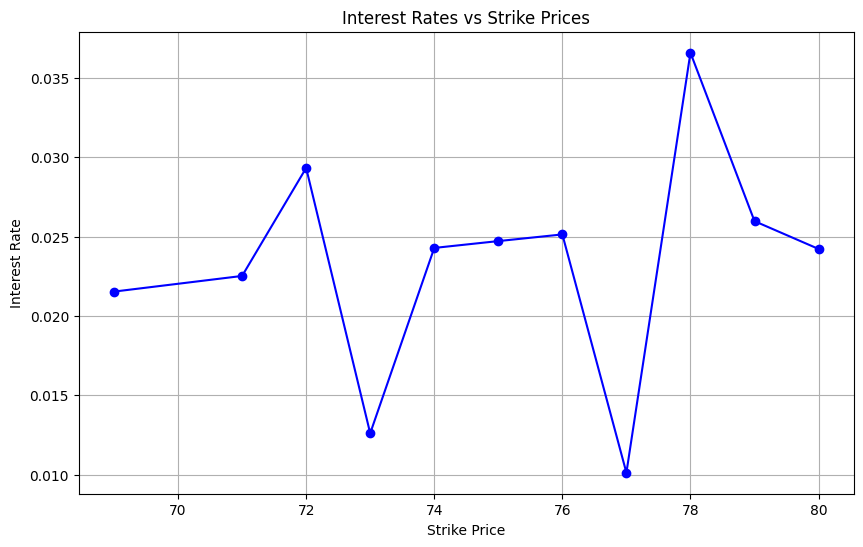

0.023362604410304855


In [7]:
# Calculate interest rates from parity
interest_rates = calculate_interest_rate_from_parity(df, q, T)
# print (interest_rates.head())

# Display the calculated interest rates
plot_interest_rates(interest_rates)

r = interest_rates['InterestRate'].mean()
print(r)
r = 0.04

In [8]:
# Store the mean interest rate in a variable
mean_interest_rate = interest_rates['InterestRate'].mean()
print(f'Mean Interest Rate: {mean_interest_rate}')

Mean Interest Rate: 0.023362604410304855


## Calculate volatility skew
Plot IV versus strike, note call are underpriced due to dividends and market crash after "liberation" day

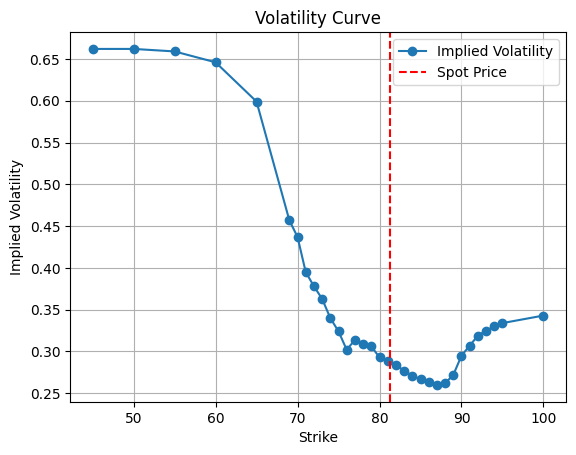

In [9]:
import matplotlib.pyplot as plt

# Add a new column for implied volatility based on the condition
df['ImpliedVolatility'] = df.apply(
    lambda row: row['IV_Put'] if row['Strike'] < S0 else row['IV_Call'], axis=1
)

# Plot the implied volatility curve
plt.plot(df['Strike'], df['ImpliedVolatility'], 'o-', label='Implied Volatility')
plt.xlabel("Strike")
plt.ylabel("Implied Volatility")
plt.title("Volatility Curve")
plt.axvline(x=S0, color='red', linestyle='--', label='Spot Price')
plt.grid(True)
plt.legend()
plt.show()

## Calibrate Bates Model
Use the Bates model to calibrate on market prices and minimize the sum of squared errors.

In [10]:
from src.bates_formula.calibration import calibrate_bates_model

data_folder = '../data/marketDataClose25-04'
all_files = [f for f in os.listdir(data_folder) if f.endswith('.csv')]
data_frames = []

for file in all_files:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    df['Source'] = file  # Add a column to identify the source file
    data_frames.append(df)

combined_data = pd.concat(data_frames, ignore_index=True)

# Add a new column 'Mid_Price' based on the condition
combined_data['Mid_Price'] = combined_data.apply(
    lambda row: (row['Bid_Call'] + row['Ask_Call']) / 2 if row['Strike'] > S0 else (row['Bid_Put'] + row['Ask_Put']) / 2,
    axis=1
)

# Display the first few rows to verify the new column
print(combined_data[['Strike', 'Bid_Call', 'Ask_Call', 'Bid_Put', 'Ask_Put', 'Mid_Price']].head())
# Extract market prices and strikes
market_prices = combined_data['Mid_Price']  # Mid prices for calls
strikes = combined_data['Strike']

# Use the mean interest rate in Bates model calibration
calibrated_params = calibrate_bates_model(market_prices, strikes, S0, T, mean_interest_rate, q)
print("Calibrated Bates Model Parameters:", calibrated_params)

   Strike  Bid_Call  Ask_Call  Bid_Put  Ask_Put  Mid_Price
0    30.0      49.4      54.0     0.10     2.25      1.175
1    35.0      44.5      48.4     0.00     1.45      0.725
2    37.5      42.1      46.0     0.00     1.50      0.750
3    40.0      39.7      43.6     0.10     0.50      0.300
4    42.5      37.2      41.4     0.15     1.20      0.675
Calibrated Bates Model Parameters: {'V0': np.float64(0.01), 'kappa': np.float64(1.948079011735589), 'eta': np.float64(0.01), 'theta': np.float64(0.2361736265912907), 'rho': np.float64(0.99), 'jump_intensity': np.float64(1.0), 'jump_mean': np.float64(-0.5), 'jump_stddev': np.float64(0.01)}
Calibrated Bates Model Parameters: {'V0': np.float64(0.01), 'kappa': np.float64(1.948079011735589), 'eta': np.float64(0.01), 'theta': np.float64(0.2361736265912907), 'rho': np.float64(0.99), 'jump_intensity': np.float64(1.0), 'jump_mean': np.float64(-0.5), 'jump_stddev': np.float64(0.01)}


## Plot Market Prices
Visualize the calibrated Bates model prices against the actual market prices.

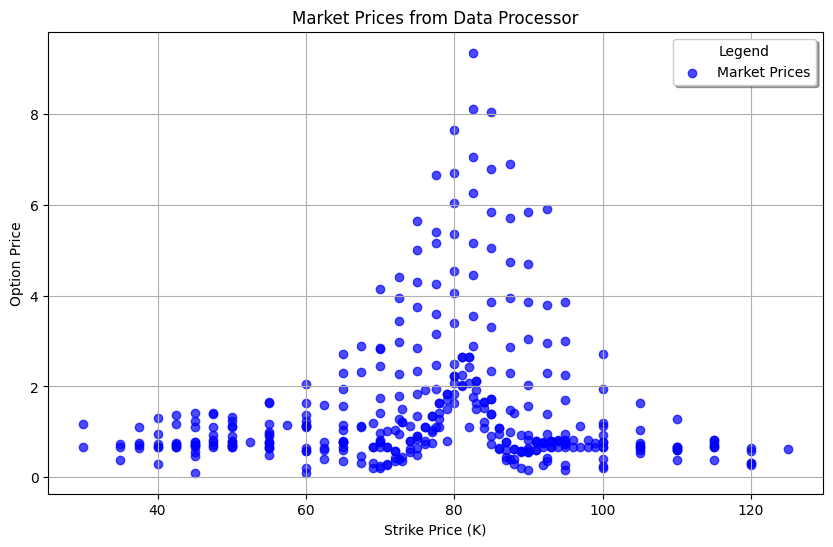

In [11]:
# Use MarketDataProcessor to load and process data
from src.data_processing.market_data_processor import MarketDataProcessor

# Initialize the MarketDataProcessor
data_folder = '../data/marketDataClose25-04'
S0 = 81.25
processor = MarketDataProcessor(data_folder, S0)
processor.load_and_process_data()

# Access the combined data
combined_data = processor.combined_data

# Plot market prices
plt.figure(figsize=(10, 6))
plt.scatter(combined_data['Strike'], combined_data['Mid_Price'], label='Market Prices', color='blue', marker='o', alpha=0.7)

# Add labels, title, and legend
plt.xlabel('Strike Price (K)')
plt.ylabel('Option Price')
plt.title('Market Prices from Data Processor')
plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
plt.grid(True)

# Show the plot
plt.show()

## Calibrate Bates Model Globally
Use the BatesModelGlobalCalibrator class to find the best parameters for all maturities combined.

In [12]:
import numpy as np

global_params = {
    'V0': np.float64(0.03314133662402323),
    'kappa': np.float64(2.0),
    'eta': np.float64(0.06797967406717075),
    'theta': np.float64(0.14987718209558357),
    'rho': np.float64(-0.99),
    'jump_intensity': np.float64(0.01),
    'jump_mean': np.float64(0.01),
    'jump_stddev': np.float64(0.01)
}

In [13]:
print(global_params)

{'V0': np.float64(0.03314133662402323), 'kappa': np.float64(2.0), 'eta': np.float64(0.06797967406717075), 'theta': np.float64(0.14987718209558357), 'rho': np.float64(-0.99), 'jump_intensity': np.float64(0.01), 'jump_mean': np.float64(0.01), 'jump_stddev': np.float64(0.01)}


In [ ]:
from src.bates_formula.calibration_global import BatesModelGlobalCalibrator

# Perform global calibration for each maturity
calibrated_results = []
for maturity, df in processor.data_by_maturity.items():
    strikes = df['Strike']
    market_prices = df['Mid_Price']

    # Initialize the global calibrator for this maturity
    global_calibrator = BatesModelGlobalCalibrator(data_folder, S0, r, q)
    global_calibrator.calibrate_global_model()

    # Retrieve calibrated parameters
    calibrated_params = global_calibrator.get_global_calibrated_params()
    calibrated_results.append((maturity, strikes, market_prices, calibrated_params))

    # Predict Bates prices using calibrated parameters
    bates_prices = BatesModel(
        S0, r, q, calibrated_params['V0'], calibrated_params['kappa'], calibrated_params['eta'],
        calibrated_params['theta'], calibrated_params['rho'], maturity, strikes=strikes,
        jump_intensity=calibrated_params['jump_intensity'], jump_mean=calibrated_params['jump_mean'],
        jump_stddev=calibrated_params['jump_stddev']
    ).price_options()

    # Plot market prices and Bates model prices
    plt.figure(figsize=(10, 6))
    plt.scatter(strikes, market_prices, label='Market Prices', color='blue', marker='o', alpha=0.7)
    plt.plot(strikes, bates_prices, label='Bates Model Prices', color='red', linestyle='--')

    # Add labels, title, and legend
    plt.xlabel('Strike Price (K)')
    plt.ylabel('Option Price')
    plt.title(f'Market Prices vs Bates Model Prices for Maturity {maturity}')
    plt.legend(title='Legend', loc='best', fancybox=True, shadow=True)
    plt.grid(True)

    # Show the plot
    plt.show()